# <center> Convolutional Neural Network

### Convolutional Layers: [512] ; Dense Layers [512]

CNN is trained on raw data

## <font color = 'blue'> Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_16_val                  -> array([[-0.86867832,  0.90982973, -0.41354501, ...
X_32_val                  -> array([[ 0.58128519,  1.18391134,  1.03769373, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.5812851
X_32train_std             -> array([[-0.8119218 ,  0.28416571, -0.9279788 , ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ -1.08940
X_test_std                -> defaultdict(<class 'list'>, {0: array([[-0.8686783
X_train                   -> array([[[-0.00749793,  0.00696769,  0.00273202, ..
X_train_std               -> array([[-0.8119218 ,  0.28416571, -0.9279788 , ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val                  -> array([0, 2, 1, ..., 1, 4, 2])
y_32_test                 -> defaultdict(<class 'list'>, {0: array([0, 7, 1, ..
y_32_train                -> array([2, 4, 3, ..., 3, 0, 0])
y_32_val                  -> array([0, 

In [2]:
print("Training data: ", X_train.shape, "and labels: ", y_train.shape)
print()
print("Test data:")
print("Total", len(X_test), X_test[18].shape, "arrays for SNR values:")
print(sorted(X_test.keys()))

Training data:  (80000, 2, 128) and labels:  (80000,)

Test data:
Total 20 (4000, 2, 128) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## <font color = 'blue'> Standardize the features

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
_X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
_X_train = sc.fit_transform(_X_train)

X_train = np.reshape(_X_train, X_train.shape)
print("Training set", X_train.shape)

_X_test = defaultdict(list)
for snr in snrs:
    _X_test[snr] = np.reshape(X_test[snr], [X_test[snr].shape[0], X_test[snr].shape[1]*X_test[snr].shape[2]])
    _X_test[snr] = sc.transform(_X_test[snr])
    X_test[snr] = np.reshape(_X_test[snr], X_test[snr].shape)
    
print("Test set corresponding to one snr value", X_test[18].shape)

Training set (80000, 2, 128)
Test set corresponding to one snr value (4000, 2, 128)


## <font color = 'blue'> Design and train the CNN

In [4]:
height = 2
width = 128
channels = 1
n_features = height * width

feature_map1 = 512
ksize_conv1 = 2
stride_conv1 = 1

pool_layer_maps1 = 512

n_fully_conn1 = 512

n_classes = 8
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
labels = tf.placeholder(tf.int32, shape=[None])

xavier_init = tf.contrib.layers.xavier_initializer()
relu_act = tf.nn.relu

# ------------------ Convolutional layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = relu_act)
    return convolutional_layer

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, xavier_init, stride_conv1, padding = "SAME")

# ----------------- Pooling layers -------------------------------------

def pooling_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

pool_layer1_flat = pooling_layer(conv_layer1, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps1 )

# ----------------- Fully connected layers -------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init)
    return fully_conn
        
dense_layer1 = dense_layer(pool_layer1_flat, n_fully_conn1, xavier_init, relu_act)

# ----------------- Output softmax layer ---------------------------

logits = tf.layers.dense(dense_layer1, n_classes)
softmax_activations = tf.nn.softmax(logits)

# ----------------- Specify performance measure -------------------------------

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
train_operation = optimizer.minimize(loss)

correct_predictions = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# ---------------- Execution phase -------------------------------------------
    
n_epochs = 10
batch_size = 1024
n_train = X_train.shape[0]
n_iter = n_train//batch_size

acc_test = defaultdict(list)

path = "./CNN_single_conv2.1"  
saver = tf.train.Saver()

start = time()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size)    
            X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
            sess.run(train_operation, feed_dict={X: X_batch, labels: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, labels: y_batch})
        print("Epoch {} training accuracy : {}".format(epoch, acc_train))
        save_path = saver.save(sess, path)
        saver.restore(sess, path)
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_test[snr], labels: y_test[snr]})

print("Training took %f minutes"%(float(time() - start)/60.0))

Epoch 0 training accuracy : 0.271484375
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 1 training accuracy : 0.35546875
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 2 training accuracy : 0.4140625
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 3 training accuracy : 0.474609375
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 4 training accuracy : 0.494140625
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 5 training accuracy : 0.5
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 6 training accuracy : 0.568359375
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 7 training accuracy : 0.5595703125
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 8 training accuracy : 0.5625
INFO:tensorflow:Restoring parameters from ./CNN_single_conv2.1
Epoch 9 training accuracy : 0.5908203125
INFO:tensorflow:Restoring parameters from ./CNN

## <font color = 'blue'> Test the classifier

In [5]:
for snr in snrs:
    print("CNN's test accuracy on {}dB SNR samples = {}".format(snr,acc_test[snr]))  

CNN's test accuracy on -20dB SNR samples = 0.12150000035762787
CNN's test accuracy on -18dB SNR samples = 0.1197500005364418
CNN's test accuracy on -16dB SNR samples = 0.14124999940395355
CNN's test accuracy on -14dB SNR samples = 0.14800000190734863
CNN's test accuracy on -12dB SNR samples = 0.17425000667572021
CNN's test accuracy on -10dB SNR samples = 0.21899999678134918
CNN's test accuracy on -8dB SNR samples = 0.2927500009536743
CNN's test accuracy on -6dB SNR samples = 0.3564999997615814
CNN's test accuracy on -4dB SNR samples = 0.4597499966621399
CNN's test accuracy on -2dB SNR samples = 0.5737500190734863
CNN's test accuracy on 0dB SNR samples = 0.6487500071525574
CNN's test accuracy on 2dB SNR samples = 0.6937500238418579
CNN's test accuracy on 4dB SNR samples = 0.7179999947547913
CNN's test accuracy on 6dB SNR samples = 0.7195000052452087
CNN's test accuracy on 8dB SNR samples = 0.7229999899864197
CNN's test accuracy on 10dB SNR samples = 0.7275000214576721
CNN's test accurac

## <font color = 'blue'> Visualize classifier's performance on test set

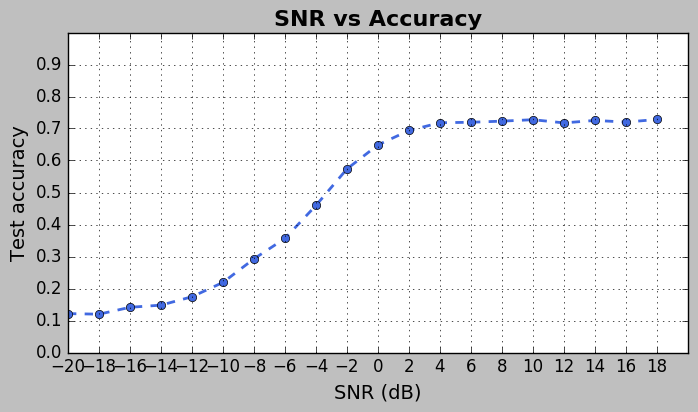

In [4]:
plt.style.use('classic')
fig1 = plt.figure(figsize=(8, 4), dpi=100)

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()